Practice Work

Title: PyTorch Deep Neural Network Design Challenge with seeds Dataset

Problem Statement: Create a DNN using PyTorch for Seeds Classification. Design a network architecture. 

In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [30]:
seeds_data = pd.read_csv("Data/seeds.csv")

sample_seeds = seeds_data.sample(10)
display(sample_seeds)

,area,perimeter,compactness,kernel_length,kernel_width,asymmetry_coefficient,groove_length,species
51,15.78,14.91,0.8923,5.674,3.434,5.5930,5.136,0
4,16.14,14.99,0.9034,5.658,3.562,1.3550,5.175,0
12,13.89,14.02,0.8880,5.439,3.199,3.9860,4.738,0
109,18.55,16.22,0.8865,6.153,3.674,1.7380,5.894,1
191,11.27,12.86,0.8563,5.091,2.804,3.9850,5.001,2
37,17.08,15.38,0.9079,5.832,3.683,2.9560,5.484,0
173,11.40,13.08,0.8375,5.136,2.763,5.5880,5.089,2
72,17.26,15.73,0.8763,5.978,3.594,4.5390,5.791,1
30,13.16,13.82,0.8662,5.454,2.975,0.8551,5.056,0
86,18.88,16.26,0.8969,6.084,3.764,1.6490,6.109,1


In [38]:
import sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_to_std = [0, 1, 2, 3, 4, 5, 6]
seeds_data.iloc[:, cols_to_std] = scaler.fit_transform(seeds_data.iloc[:, cols_to_std])

display(seeds_data)

,area,perimeter,compactness,kernel_length,kernel_width,asymmetry_coefficient,groove_length,species
0,0.142098,0.215462,0.000061,0.304218,0.141702,-0.986152,-0.383577,0
1,0.011188,0.008224,0.428515,-0.168625,0.197432,-1.788166,-0.922013,0
2,-0.192067,-0.360201,1.442383,-0.763637,0.208048,-0.667479,-1.189192,0
3,-0.347091,-0.475333,1.039381,-0.688978,0.319508,-0.960818,-1.229983,0
4,0.445257,0.330595,1.374509,0.066666,0.805159,-1.563495,-0.475356,0
...,...,...,...,...,...,...,...,...
205,-0.915515,-1.043321,0.309736,-1.112048,-0.736716,-0.046135,-1.097413,2
206,-1.246235,-1.288937,-0.844122,-1.105261,-1.230328,0.416540,-0.826156,2
207,-0.567571,-0.690247,0.733948,-0.888070,-0.070604,3.076588,-0.718060,2
208,-1.036090,-1.035645,-0.801701,-1.026077,-1.121521,-0.068135,-0.742535,2


In [91]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

species = seeds_data["species"]
X_train, X_test, y_train, y_test = train_test_split(seeds_data.iloc[:, cols_to_std], species, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.long)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

In [96]:
import torch.nn.functional as F 

class SeedsClassifier(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(SeedsClassifier, self).__init__()

        self.input_layer = nn.Linear(num_features, hidden_dim)
        self.nn1 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        
        x = self.nn1(x)
        x = F.relu(x)

        x = self.output_layer(x)

        return x



In [97]:
import tqdm

model = SeedsClassifier(num_features=7, hidden_dim=32, output_dim=3)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

def train(model, data_loader, optimizer):
    model.train()
    train_loss = 0

    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        optimizer.zero_grad()
        output = model(data)

        loss = loss_fn(output, target)
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()
    
    avg_loss = train_loss / (batch + 1)
    return avg_loss


In [98]:
def test_model(model, data_loader):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor

            output = model(data)

            loss = loss_fn(output, target)
            total_loss += loss.item()

            _, predicted = torch.max(output.data, 1)

            correct += torch.sum(target==predicted).item()

        avg_loss = total_loss / len(data_loader)
        return avg_loss, correct


In [99]:
from torch.utils.data import DataLoader

data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
total_train_losses = []

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

data_loader_test = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
total_test_losses = []

for epoch in range(30):
    train_loss = train(model, data_loader, optimizer)
    total_train_losses.append(train_loss)

    test_loss = test_model(model, data_loader_test)[0]
    total_test_losses.append(test_loss)

    print(f"Epoch {epoch + 1}, Train Loss = {train_loss}")
    print(f"Epoch {epoch + 1}, Test Loss = {test_loss}")

Epoch 1, Train Loss = 1.118768076101939
Epoch 1, Test Loss = 1.0906766653060913
Epoch 2, Train Loss = 1.061238984266917
Epoch 2, Test Loss = 1.0389912128448486
Epoch 3, Train Loss = 1.0081288715203602
Epoch 3, Test Loss = 0.9865956902503967
Epoch 4, Train Loss = 0.9615437785784403
Epoch 4, Test Loss = 0.9318177103996277
Epoch 5, Train Loss = 0.9080884555975596
Epoch 5, Test Loss = 0.8721706867218018
Epoch 6, Train Loss = 0.8479263484477997
Epoch 6, Test Loss = 0.8095545768737793
Epoch 7, Train Loss = 0.7871607144673666
Epoch 7, Test Loss = 0.7430211901664734
Epoch 8, Train Loss = 0.7461142539978027
Epoch 8, Test Loss = 0.6753594279289246
Epoch 9, Train Loss = 0.6350563863913218
Epoch 9, Test Loss = 0.6112212538719177
Epoch 10, Train Loss = 0.5900446971257528
Epoch 10, Test Loss = 0.5494397878646851
Epoch 11, Train Loss = 0.527058427532514
Epoch 11, Test Loss = 0.49450960755348206
Epoch 12, Train Loss = 0.47897760570049286
Epoch 12, Test Loss = 0.4477594792842865
Epoch 13, Train Loss = 

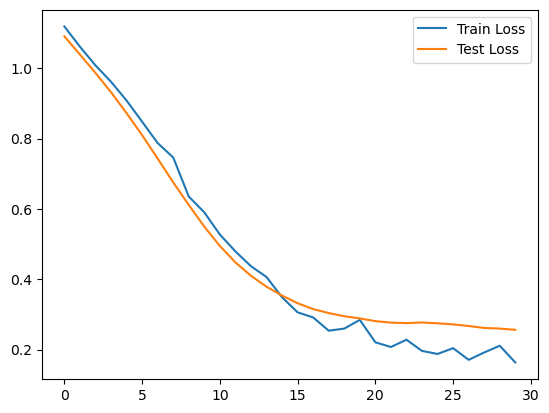

In [100]:
import matplotlib.pyplot as plt 
total_train_losses = np.array(total_train_losses)
plt.plot(total_train_losses, label="Train Loss")
plt.plot(total_test_losses, label="Test Loss")
plt.legend()
plt.show()